<a href="https://colab.research.google.com/github/EAkeweje/Accelerating-Hydrogen-Oxidation-Calculations/blob/main/RNN_based_with_Wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import and login
import wandb

wandb.login()

wandb: Currently logged in as: data-bigwig. Use `wandb login --relogin` to force relogin


True

In [2]:
%cd '/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation'

/Volumes/GoogleDrive/My Drive/Skoltech/Research/Hydrogen Oxidation


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import PIL
import pandas as pd
from tqdm.notebook import tqdm
import json
import time
import cv2
import random
import glob
import os
import copy
from sklearn.metrics import r2_score

## Utils

In [4]:
#Dataset object
class OxidationDataset(Dataset):

    def __init__(self, inputs_path, outputs_dir, nsample, ntimesteps):
        """
        Args:
            inputs_dir (string): 
            outputs_dir (string):
        """
        
        # x = np.loadtxt(inputs_path, skiprows = 1, delimiter= ',')
        # x = np.loadtxt(inputs_path, delimiter= ' ')
        with open(inputs_path, 'rb') as f:
          x = np.load(f)
        #drop inert gases
        self.inputs = np.delete(x[ :nsample, :], [0, 3, 8,9], 1)[:, np.newaxis] #exclude H2, O2 and the inert gases
        self.out_dir = outputs_dir
        self.ntimesteps = ntimesteps


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        #get output
        # Y = np.loadtxt(os.path.join(self.out_dir, f'out{idx}.txt'), delimiter= ';')
        with open(os.path.join(self.out_dir, f'out{idx}.npy'), 'rb') as f:
          Y = np.load(f)

        #drop inert gases
        if type(self.ntimesteps) == int:
            Y = Y[:self.ntimesteps, 1:-2]
        elif type(self.ntimesteps) == list:
            Y = Y[self.ntimesteps, 1:-2]
        elif self.ntimesteps == 'all':
            Y = Y[:, 1:-2]
        else:
            raise ValueError("Invalid argument 'ntimestep' should an interger, a list or 'all' string")
        #excluding H2 and O2
        Y = np.delete(Y, [1,4])

        return torch.from_numpy(self.inputs[idx]), torch.from_numpy(Y)

In [5]:
#for data standardization
def standardize(tensor, dim = 0, mean = None, std = None) -> torch.float64:
    tensor = tensor.float()

    if mean is None:
        mean = tensor.mean(dim = dim, keepdim = True)

    if std is None:
        std = tensor.std(dim = dim, keepdim = True)

    standard_tensor = (tensor - mean) / std
    return standard_tensor, mean, std

def inverse_standardize(tensor, dim, mean, std):
    tensor = tensor.float()
    return tensor * std + mean

In [6]:
def load_mean_std(path, loader = None):
  if os.path.exists(path):
    #get means and stds
    with open(path, 'r') as f:
        mean_std_dict = json.load(f)
    train_x_mean = torch.tensor(mean_std_dict['mean_x'])
    train_x_std = torch.tensor(mean_std_dict['std_x'])
    train_y_mean = torch.tensor(mean_std_dict['mean_y'])
    train_y_std = torch.tensor(mean_std_dict['std_y'])
    return train_x_mean, train_x_std, train_y_mean, train_y_std
  else:
    return save_mean_std(loader, path, output = True)
  

In [7]:
def save_mean_std(loader, path, output = False):
  '''
  loader:: preferably train loader
  path:: a json path
  output:: bool: to output the means and stds
  '''
  #obtaining mean and std of training set
  train_x = []
  train_y = []
  for x,y in loader:
      train_x.append(x)
      train_y.append(y)

  _, train_x_mean, train_x_std = standardize(torch.concat(train_x), 0)
  _, train_y_mean, train_y_std = standardize(torch.concat(train_y), 0)

  #write to disc
  mean_std_dict = {
      'mean_x' : train_x_mean.tolist(),
      'mean_y' : train_y_mean.tolist(),
      'std_x' : train_x_std.tolist(),
      'std_y' : train_y_std.tolist()
  }

  with open(path, 'w') as f:
    json.dump(mean_std_dict, f)
  
  if output:
    return train_x_mean, train_x_std, train_y_mean, train_y_std

In [8]:
def train_step(model, optimizer, criterion, dataloader, mean_std, device, mb_coeff = 0):
  '''
  Do one training epoch.
  mb_coeff is material balance weight. If mb_coeff == 0, then material balance is not considered.
  '''
  train_loss_ = 0.0
  model.train()
  for input, target in dataloader:
    # Transfer Data to GPU if available
    input, target = input.to(device), target.to(device)
    # Standardize
    input, _, _ = standardize(input, 0, mean_std[0], mean_std[1])
    target, _, _ = standardize(target, 0, mean_std[2], mean_std[3])
    # Forward Pass
    predict = model(input.float())
    # Find loss
    if mb_coeff != 0:
      #Material Balance
      T_H_true, T_H_pred, T_O_true, T_O_pred = total_material(target, predict)
      loss = criterion(predict,target.float()) + mb_coeff * criterion(T_H_pred, T_H_true) + mb_coeff * criterion(T_O_pred, T_O_true)
    else:
      loss = criterion(predict, target.float())
    # Clear the gradients
    optimizer.zero_grad()
    # Calculate gradients
    loss.backward()
    # Update Weights
    optimizer.step()
    # Calculate Loss
    train_loss_ += loss.item() 
  return train_loss_

def valid_step(model, criterion, dataloader, mean_std, device, mb_coeff = 0):
  valid_loss_ = 0.0
  model.eval()     # Optional when not using Model Specific layer
  for input, target in dataloader:
    # Transfer Data to GPU if available
    input, target = input.to(device), target.to(device)
    #standardize
    input, _, _ = standardize(input, 0, mean_std[0], mean_std[1])
    target, _, _ = standardize(target, 0, mean_std[2], mean_std[3])
    # Forward Pass
    predict = model(input.float())
    # Find the Loss
    if mb_coeff != 0:
      #Material Balance
      T_H_true, T_H_pred, T_O_true, T_O_pred = total_material(target, predict)
      loss = criterion(predict,target.float()) + mb_coeff * criterion(T_H_pred, T_H_true) + mb_coeff * criterion(T_O_pred, T_O_true)
    else:
      loss = criterion(predict,target.float())
    # Calculate Loss
    valid_loss_ += loss.item()
  return valid_loss_

In [9]:
def loss_plot(train_loss, valid_loss):
  plt.figure(figsize = (10,7))
  epochs = len(train_loss)
  epochs2 = len(valid_loss)
  plt.plot(range(epochs),train_loss,'-r',label = 'Training loss')
  plt.plot(range(epochs2),valid_loss,'-b',label = 'Validation loss')
  plt.yscale('log')
  plt.legend(fontsize=15)
  plt.grid()
  plt.xlabel('epochs', fontsize=15)
  plt.ylabel('MSE', fontsize=15)
  plt.show()
# plt.title(f'Loss curve (2ks {len(dataset.guage_space)}sensor)', fontsize = 20)}

In [10]:
def total_material(y_true, y_pred):
  '''
  Computes the total material (moles) of Hydrogen and Oxygen in product.
  y_true: ground truth
  y_pred: (model) prediction
  '''
  assert y_true.ndim == y_pred.ndim, f'Tensors are of different dimensions: {y_true.ndim} and {y_pred.ndim}'
  assert y_true.shape == y_pred.shape, f'Shape of tensor are different: {y_true.shape} and {y_pred.shape}'
  assert y_true.ndim < 4, f'Tensor dimension must be less than 4: {y_true.ndim}'

  if y_true.ndim == 1:
    T_H_true = 2*y_true[1] + y_true[2] + y_true[5]+ 2*y_true[6] + y_true[7]+ 2*y_true[8]
    T_H_pred = 2*y_pred[1] + y_pred[2] + y_pred[5]+ 2*y_pred[6] + y_pred[7]+ 2*y_pred[8]
    T_O_true = y_true[3] + 2*y_true[4] + y_true[5]+ y_true[6] + 2*y_true[7]+ 2*y_true[8]
    T_O_pred = y_pred[3] + 2*y_pred[4] + y_pred[5]+ y_pred[6] + 2*y_pred[7]+ 2*y_pred[8]

  elif y_true.ndim == 2:
    T_H_true = 2*y_true[:,1] + y_true[:,2] + y_true[:,5]+ 2*y_true[:,6] + y_true[:,7]+ 2*y_true[:,8]
    T_H_pred = 2*y_pred[:,1] + y_pred[:,2] + y_pred[:,5]+ 2*y_pred[:,6] + y_pred[:,7]+ 2*y_pred[:,8]
    T_O_true = y_true[:,3] + 2*y_true[:,4] + y_true[:,5]+ y_true[:,6] + 2*y_true[:,7]+ 2*y_true[:,8]
    T_O_pred = y_pred[:,3] + 2*y_pred[:,4] + y_pred[:,5]+ y_pred[:,6] + 2*y_pred[:,7]+ 2*y_pred[:,8]
  
  elif y_true.ndim == 3:
    T_H_true = 2*y_true[:,:,1] + y_true[:,:,2] + y_true[:,:,5]+ 2*y_true[:,:,6] + y_true[:,:,7]+ 2*y_true[:,:,8]
    T_H_pred = 2*y_pred[:,:,1] + y_pred[:,:,2] + y_pred[:,:,5]+ 2*y_pred[:,:,6] + y_pred[:,:,7]+ 2*y_pred[:,:,8]
    T_O_true = y_true[:,:,3] + 2*y_true[:,:,4] + y_true[:,:,5]+ y_true[:,:,6] + 2*y_true[:,:,7]+ 2*y_true[:,:,8]
    T_O_pred = y_pred[:,:,3] + 2*y_pred[:,:,4] + y_pred[:,:,5]+ y_pred[:,:,6] + 2*y_pred[:,:,7]+ 2*y_pred[:,:,8]
  
  return T_H_true, T_H_pred, T_O_true, T_O_pred


In [11]:
###Networks
#single step
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.linear(out)
        return out
    
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight, nonlinearity= 'relu')
        m.bias.data.fill_(0.0)

###multiple time steps
#one to many RNN architechture
class Base_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Base_RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.input_size)
        
    def forward(self, x, in_hidden = None):
        if in_hidden == None:
            out, out_hidden = self.rnn(x)
        else:
            out, out_hidden = self.rnn(x, in_hidden)
        out = self.linear(out)
        return out, out_hidden

class RNN_Model_Multiple(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size, ntimesteps):
        super(RNN_Model_Multiple, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.ntimesteps = ntimesteps
        self.base_rnn = Base_RNN(self.input_size, self.hidden_size, self.num_layers)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.input_size, self.output_size)
        
    def forward(self, x):
        out = x
        hidden = None
        
        #to store outputs
        outputs = []
        
        for t in range(self.ntimesteps):                
            #pass to rnn
            out, hidden = self.base_rnn(out, hidden)
            #pass to output layer
            outputs.append(self.linear(self.relu(out)))
            #skip connection
            out += x

        return torch.concat(outputs, 1)

#one to many RNN architechture
class Base_RNN_v2(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers):
        super(Base_RNN_v2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.output_size, self.hidden_size, self.num_layers, dropout = 0.1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, in_hidden = None):
        if in_hidden == None:
            out, out_hidden = self.rnn(x)
        else:
            out, out_hidden = self.rnn(x, in_hidden)
        out = self.linear(out)
        return out, out_hidden

class RNN_Model_Multiple_v2(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size, ntimesteps):
        super(RNN_Model_Multiple_v2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.ntimesteps = ntimesteps
        self.base_rnn = Base_RNN_v2(self.output_size, self.hidden_size, self.num_layers)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.input_size, self.output_size)

    def forward(self, x):
        #pass to first layer and activation
        x = self.relu(self.linear(x))

        #to store outputs
        outputs = []

        #set inputs to first RNN layer
        out = x
        hidden = None

        #loop through rnn layers
        for t in range(self.ntimesteps):                
            #pass to rnn
            out, hidden = self.base_rnn(out, hidden)
            #pass to output layer
            outputs.append(out)
            #skip connection
            out += x

        return torch.concat(outputs, 1)

In [12]:
def make_dataloaders(config):
    '''
    batch_size: int = batch size
    ntimesteps: int or list = number/list of time steps in data
    nsample: int = number of samples to use
    split: list = list of train set to data ration and train+valid set to data ratio
    '''
    #initialize dataset object
    dataset = OxidationDataset(inputs_path = 'input_98660.npy',#'input_98660.txt',
                               outputs_dir = './Out_files_npy',
                               nsample = config.nsample,
                               ntimesteps = config.timesteps)
    # Creating Training, Validation, and Test dataloaders
    # split Train : Val : Test = 0.7 : 0.2 : 0.1
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_split = int(np.floor(config.split[0] * dataset_size))
    val_split = int(np.floor(config.split[1] * dataset_size))
    shuffle_dataset = True
    random_seed = 42
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices = indices[ : train_split]
    val_indices = indices[train_split : train_split + val_split]
    test_indices = indices[train_split + val_split : ]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size = config.batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size = config.batch_size, sampler=valid_sampler)
    test_loader = DataLoader(dataset, batch_size = config.batch_size, sampler=test_sampler)
    
    return train_loader, validation_loader, test_loader

def to_device(model, train_x_mean, train_x_std, train_y_mean, train_y_std):
  if torch.cuda.is_available():
    model = model.cuda()
    train_x_mean = train_x_mean.cuda()
    train_x_std = train_x_std.cuda()
    train_y_mean = train_y_mean.cuda()
    train_y_std = train_y_std.cuda()

In [13]:
def training(model, train_loader, val_loader, config, criterion, mean_std, device, dict_path):
  '''
  model:: Neural network
  epoch:: 
  optimizer:: optimization algorithm. Default Adam
  learning rate:: 
  dict_path:: path to save best model's state_dict
  criterion:: loss function. Default = nn.MSELoss()
  scheduler:: schedule learning rate. Default = False
  mb_coeff :: Weight for material balance inclusion. Default = 0
  '''
  min_valid_loss = np.inf
  # train_loss = []
  # valid_loss = []

  if config.optimizer == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr, betas = (config.beta1, config.beta2))
  elif config.optimizer == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr = config.lr, momentum= config.SGD_momentum)
  else:
    raise ValueError(f'Unknown optimizer ({config.optimizer})')

  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
  no_save = 0 #for early stopping

  for e in range(config.epochs):
    train_loss_ = train_step(model, optimizer, criterion, train_loader, mean_std, device, config.mb_coeff)
    valid_loss_ = valid_step(model, criterion, val_loader, mean_std, device, config.mb_coeff)

    wandb.log({"train_loss": train_loss_/len(train_loader),
               "val_loss": valid_loss_/len(val_loader)})

    if config.scheduling:
      scheduler.step()

    if min_valid_loss > valid_loss_:
        min_valid_loss = valid_loss_

        no_save = 0 #reset counter
        # Saving State Dict
        if dict_path != None:
          torch.save(model.state_dict(), dict_path)
        
    else:
      no_save += 1

    # Early stopping
    if no_save >= 200:
      break

  return e, min_valid_loss

#Training

In [14]:
# Config
params = dict(
    ## data
    batch_size = 16,
    timesteps = 'all',
    nsample = 1500,
    split = [0.7, 0.2, 0.1],
    mean_std_path = 'rnn_NoH2_O2_all_mean_std.json',
    ## model
    input_size = 8,
    hidden_size = 100,
    num_layers = 2,
    output_size = 7,
    ntimesteps = 201,
    ## training
    epochs = 500,
    optimizer = 'Adam',
    SGD_momentum = 0.9,
    beta1 = 0.95, 
    beta2 = 0.9,
    lr = 0.001,
    dict_path = 'rnn_NoH2_O2_all.pth', #lr_momentum
    scheduling = True,
    mb_coeff = 0,
    model = 'v1'
    )

params

{'batch_size': 16,
 'timesteps': 'all',
 'nsample': 1500,
 'split': [0.7, 0.2, 0.1],
 'mean_std_path': 'rnn_NoH2_O2_all_mean_std.json',
 'input_size': 8,
 'hidden_size': 100,
 'num_layers': 2,
 'output_size': 7,
 'ntimesteps': 201,
 'epochs': 500,
 'optimizer': 'Adam',
 'SGD_momentum': 0.9,
 'beta1': 0.95,
 'beta2': 0.9,
 'lr': 0.001,
 'dict_path': 'rnn_NoH2_O2_all.pth',
 'scheduling': True,
 'mb_coeff': 0,
 'model': 'v1'}

In [15]:
with wandb.init(project = 'Hyrogen-Oxidation-Models',name = 'First Without $H_2$ and $O_2$', config= params):
    # access all HPs through wandb.config, so logging matches execution!
    config = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mean_std_path = config.mean_std_path
    input_size = config.input_size
    output_size = config.output_size
    dict_path = config.dict_path

    #Get data
    train_loader, val_loader, test_loader = make_dataloaders(config)
    #obtaining mean and std of training set
    train_x_mean, train_x_std, train_y_mean, train_y_std = load_mean_std(mean_std_path, train_loader)
    #initialize model
    if config.model == 'v1':
        model = RNN_Model_Multiple(input_size, config.hidden_size, config.num_layers, output_size, config.ntimesteps)
    elif config.model == 'v2':
        model = RNN_Model_Multiple_v2(input_size, config.hidden_size, config.num_layers, output_size, config.ntimesteps)
    model.apply(init_weights)
    #training
    model = model.to(device)
    mean_std = [train_x_mean.to(device), train_x_std.to(device), train_y_mean.to(device), train_y_std.to(device)]
    criterion  = nn.MSELoss()
    epochs, val_loss = training(model, train_loader, val_loader, config, criterion, mean_std, device, dict_path)
    wandb.log({'loss': val_loss})
    wandb.log({'num_epochs': epochs})

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/Users/emmanuelakeweje/opt/anaconda3/lib/python3.8/site-packages/wandb/filesync/step_checksum.py", line 85, in _thread_body
    shutil.copy2(req.path, path)
  File "/Users/emmanuelakeweje/opt/anaconda3/lib/python3.8/shutil.py", line 436, in copy2
    copystat(src, dst, follow_symlinks=follow_symlinks)
  File "/Users/emmanuelakeweje/opt/anaconda3/lib/python3.8/shutil.py", line 396, in copystat
    lookup("chflags")(dst, st.st_flags, follow_symlinks=follow)
PermissionError: [Errno 1] Operation not permitted: '/var/folders/fn/s76qlgpx53b64n471qn2ylkc0000gn/T/tmpckw1vx71wandb/2r5jolzu-wandb-metadata.json'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/emmanuelakeweje/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/emmanuelakeweje/opt/anaconda3/lib/python3.8/threading.py", line 870, in run
  

wandb: ERROR Control-C detected -- Run data was not synced


RuntimeError: The size of tensor a (7) must match the size of tensor b (1807) at non-singleton dimension 2

# Inference

In [ ]:
## data
batch_size = 32
timesteps = 'all'
nsample = 1500
split = [0.7, 0.2, 0.1]
mean_std_path = 'rnn_all_mean_std.json'
## model
input_size = 10
hidden_size = 32
num_layers = 2
output_size = 9
ntimesteps = 201

dict_path = './Models/best_rnn_all.pth' #lr_momentum

train_loader, val_loader, test_loader = make_dataloaders( batch_size,  timesteps,  nsample,  split)
#obtaining mean and std of training set
train_x_mean, train_x_std, train_y_mean, train_y_std = load_mean_std( mean_std_path)
#model
model = RNN_Model_Multiple( input_size,  hidden_size,  num_layers,  output_size,  ntimesteps)
model.apply(init_weights)
model.load_state_dict(torch.load(dict_path, map_location=torch.device('cpu')))
if torch.cuda.is_available():
    model = model.cuda()
    train_x_mean = train_x_mean.cuda()
    train_x_std = train_x_std.cuda()
    train_y_mean = train_y_mean.cuda()
    train_y_std = train_y_std.cuda()
model.eval()

RNN_Model_Multiple(
  (base_rnn): Base_RNN(
    (rnn): RNN(10, 32, num_layers=2, batch_first=True, dropout=0.1)
    (linear): Linear(in_features=32, out_features=10, bias=True)
  )
  (relu): ReLU()
  (linear): Linear(in_features=10, out_features=9, bias=True)
)

In [ ]:
##NME
target_stack = []
predict_stack = []
for i, (input, target) in enumerate(val_loader):
  if torch.cuda.is_available():
      input, target = input.cuda(), target.cuda()

  #standardize
  input, _, _ = standardize(input, 0, train_x_mean, train_x_std)
  target, _, _ = standardize(target, 0, train_y_mean, train_y_std)

  pred = model(input.float())
  predict_stack.append(pred)#inverse_standardize(pred, 0, train_y_mean, train_y_std))
  target_stack.append(target)

error = torch.linalg.norm(torch.concat(target_stack) - torch.concat(predict_stack))/torch.linalg.norm(torch.concat(target_stack))
print(f'Normalized Error: {error}')

Normalized Error: 0.15740376710891724


In [ ]:
r2_score(torch.concat(target_stack).flatten().detach().cpu().numpy(), torch.concat(predict_stack).flatten().detach().cpu().numpy())

0.9750529857689033

In [ ]:
#visualization
def result_plot(y_test, pred):
    fig, ax = plt.subplots(3, 3, figsize=(20,15))
    title =  [ 'T', 'H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2']
    for i in range(9):
        a = i//3; b= i%3
        ax[a,b].scatter(pred[:,i], y_test[:,i])
        ax[a,b].plot(np.arange(y_test[:,i].min(), y_test[:,i].max()), 
                     np.arange(y_test[:,i].min(), y_test[:,i].max()), '--k')
        ax[a,b].set_title(title[i])
        ax[a,b].set_xlabel('Prediction')
        ax[a,b].set_ylabel('Groundtruth')
    plt.show()

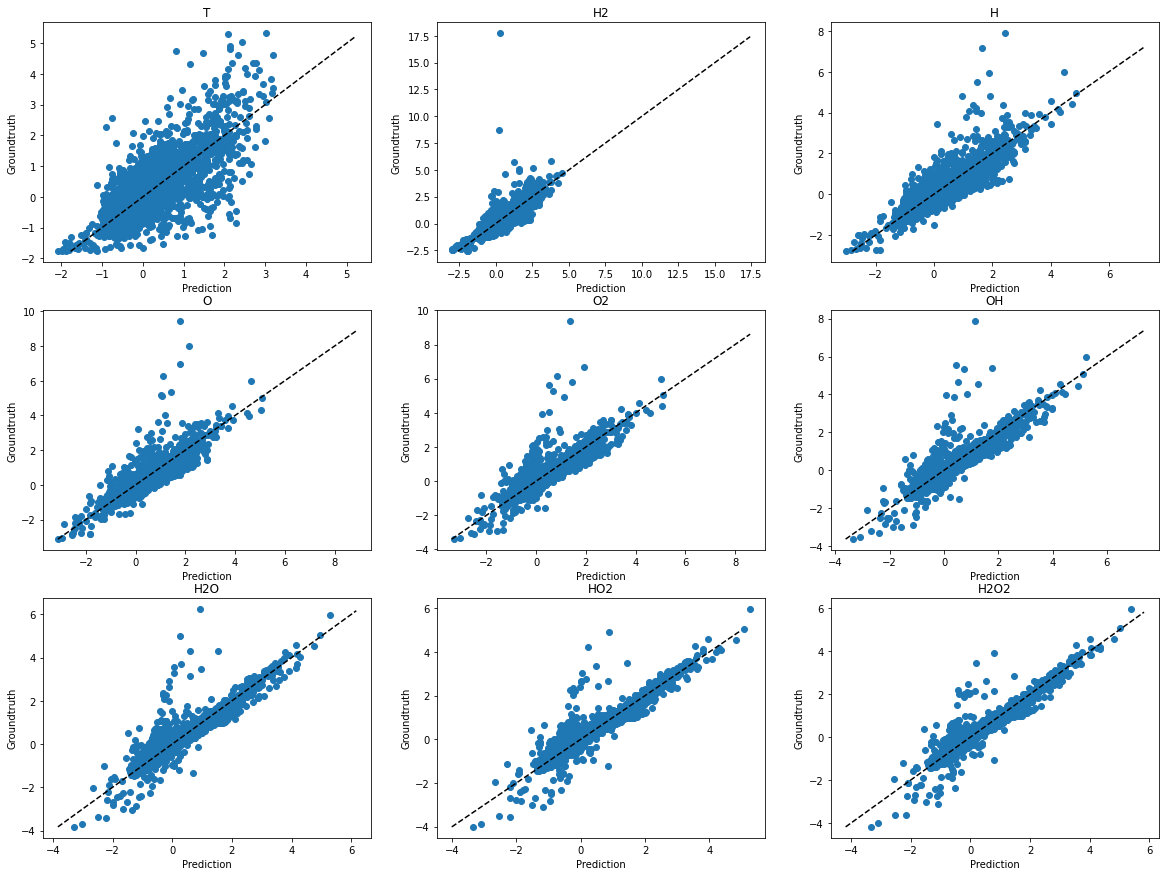

In [ ]:
result_plot(torch.concat(target_stack).detach().squeeze().cpu(),
            torch.concat(predict_stack).detach().squeeze().cpu())

In [ ]:
#test with last input from input.txt (row 197)
model.eval()
x_test = torch.tensor([[[0.345863,0.037831,0.074332,0.318219,0.061714,0.161887,4.7e-05,0.000106,290634.0,1684.0]]])#0.294903, 0.098913, 0.061895, 0.396953, 0.039459, 0.107669, 0.000127, 0.000081, 381430.000000, 2804.000000])
#standardize
x_test, _, _ = standardize(x_test, 0, train_x_mean, train_x_std)
pred_test = model(x_test)
y_test = torch.from_numpy(np.loadtxt('./Out_files_197/out4.txt', delimiter= ';')[-1, 1:-2])
y_test, _, _ = standardize(y_test, 0, train_y_mean, train_y_std)

In [ ]:
torch.sum(torch.square(y_test - pred_test))/torch.sum(torch.square(y_test))

tensor(0.0429, grad_fn=<DivBackward0>)

In [ ]:
r2_score(y_test.flatten().detach().cpu().numpy(), pred_test.flatten().detach().cpu().numpy())

0.6748446876516665

In [ ]:
# y_test.shape, pred_test.squeeze().shape
y_test.unsqueeze(dim = 0), pred_test.squeeze(dim = 0)#

(tensor([[[[ 1.0836, -1.1254, -0.7881,  ..., -0.0448, -0.7199, -1.4907],
           [ 0.9131, -0.9322, -1.0471,  ..., -0.5619, -0.7735, -0.5985],
           [ 0.6824, -0.8743, -1.0565,  ..., -0.5839, -0.8387, -0.6754],
           ...,
           [-0.3405, -0.8148, -0.8087,  ..., -0.6129, -0.5829, -0.5573],
           [-0.3405, -0.8148, -0.8087,  ..., -0.6129, -0.5829, -0.5573],
           [-0.3406, -0.8148, -0.8087,  ..., -0.6129, -0.5829, -0.5573]]]]),
 tensor([[-0.4123, -0.8769, -0.8973,  ..., -0.7258, -0.7335, -0.6686],
         [-1.1070, -0.9046, -0.9736,  ..., -0.6045, -0.6613, -0.6165],
         [-0.9350, -0.9262, -0.9218,  ..., -0.6412, -0.4342, -0.4194],
         ...,
         [-0.3460, -0.8545, -0.9113,  ..., -0.5902, -0.5073, -0.5019],
         [-0.3460, -0.8545, -0.9113,  ..., -0.5902, -0.5073, -0.5019],
         [-0.3460, -0.8545, -0.9113,  ..., -0.5902, -0.5073, -0.5019]],
        grad_fn=<SqueezeBackward1>))

In [ ]:
total_material(y_test, pred_test)

(tensor([[-6.9995, -6.2299, -6.5206, -6.6491, -6.6999, -6.6958, -6.6502, -6.5838,
          -6.5124, -6.4453, -6.3856, -6.3339, -6.2899, -6.2523, -6.2203, -6.1928,
          -6.1692, -6.1487, -6.1309, -6.1152, -6.1013, -6.0889, -6.0776, -6.0675,
          -6.0584, -6.0501, -6.0426, -6.0357, -6.0294, -6.0236, -6.0183, -6.0135,
          -6.0090, -6.0049, -6.0011, -5.9975, -5.9942, -5.9912, -5.9884, -5.9858,
          -5.9833, -5.9811, -5.9789, -5.9770, -5.9752, -5.9735, -5.9718, -5.9703,
          -5.9689, -5.9676, -5.9663, -5.9651, -5.9640, -5.9630, -5.9620, -5.9611,
          -5.9602, -5.9594, -5.9586, -5.9578, -5.9571, -5.9564, -5.9558, -5.9552,
          -5.9547, -5.9541, -5.9536, -5.9532, -5.9527, -5.9523, -5.9519, -5.9515,
          -5.9512, -5.9508, -5.9505, -5.9502, -5.9499, -5.9496, -5.9494, -5.9491,
          -5.9489, -5.9486, -5.9484, -5.9482, -5.9480, -5.9479, -5.9477, -5.9475,
          -5.9474, -5.9472, -5.9470, -5.9469, -5.9468, -5.9466, -5.9465, -5.9464,
          -5.946

# Model Optimization

In [15]:
#Define the sweep
sweep_config = {
    'name': 'Accelerating Hydrogen Oxidation Calculations',
    'description': 'Model Optimization for Adam Optimizer',
    'method': 'random', #how sweep controller select hyperparameter
    'metric': {'name': 'loss',
               'goal': 'minimize'}
                }
sweep_config

In [16]:
param_dict = {
    'batch_size': {
        'values': [8, 16, 32]
        },
    'timesteps': {
        'value': 'all'
        },
    'nsample': {
        'value': 1500
        },
    'hidden_size': {
        'values': [20, 40, 60, 80, 100]
        },
    'num_layers': {
        'values': [2, 3, 4]
        },
    'ntimesteps': {
        'value': 201
        },
    'epochs': {
        'value': 1000
        },
    'early_stopping': {
        'values': [True, False]
        },
    'optimizer': {
        'value': 'Adam'
        },
    'lr': {
      'values': [5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
        },
    'beta1': {
        'values': [0.85, 0.9, 0.95]
        },
    'beta2': {
        'values': [0.9, 0.95, 0.99]
        },
    'mb_coeff': {
        'values': [0, 0.1]
        },
    'scheduling': {
        'values': [True, False]
       },
    'model': {
        'values': ['v1', 'v2']
    },
    'split': {
        'value': [0.7, 0.2, 0.1]
    },
    'dict_path':{
        'value': None
    }
    }

sweep_config['parameters'] = param_dict

In [17]:
sweep_config

In [ ]:
# Initialize Sweep
sweep_id = wandb.sweep(sweep_config, project="Hydrogen-Oxidation-Models-Optimization")

Create sweep with ID: qvxky6fx
Sweep URL: https://wandb.ai/data-bigwig/Hydrogen-Oxidation-Models-Optimization/sweeps/qvxky6fx


In [18]:
def train_model(config = None):
  # tell wandb to get started
  with wandb.init(config=config):
  # access all HPs through wandb.config, so logging matches execution!
    config = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mean_std_path = 'rnn_all_mean_std.json'
    input_size = 10
    output_size = 9
    dict_path = None

    #Get data
    train_loader, val_loader, test_loader = make_dataloaders(config)
    #obtaining mean and std of training set
    train_x_mean, train_x_std, train_y_mean, train_y_std = load_mean_std(mean_std_path)
    #initialize model
    if config.model == 'v1':
      model = RNN_Model_Multiple(input_size, config.hidden_size, config.num_layers, output_size, config.ntimesteps)
    elif config.model == 'v2':
      model = RNN_Model_Multiple_v2(input_size, config.hidden_size, config.num_layers, output_size, config.ntimesteps)
    model.apply(init_weights)
    #training
    model = model.to(device)
    mean_std = [train_x_mean.to(device), train_x_std.to(device), train_y_mean.to(device), train_y_std.to(device)]
    criterion  = nn.MSELoss()
    epochs, val_loss = training(model, train_loader, val_loader, config, criterion, mean_std, device, dict_path)
    wandb.log({'loss': val_loss})
    wandb.log({'num_epochs': epochs})

In [19]:
sweep_id = 'qvxky6fx'

In [20]:
wandb.agent(sweep_id, train_model, project="Hydrogen-Oxidation-Models-Optimization", count=20)

wandb: Agent Starting Run: 7a4p6mau with config:
wandb: 	batch_size: 8
wandb: 	beta1: 0.9
wandb: 	beta2: 0.95
wandb: 	dict_path: None
wandb: 	early_stopping: True
wandb: 	epochs: 1000
wandb: 	hidden_size: 20
wandb: 	lr: 0.005
wandb: 	mb_coeff: 0.1
wandb: 	model: v2
wandb: 	nsample: 1500
wandb: 	ntimesteps: 201
wandb: 	num_layers: 2
wandb: 	optimizer: Adam
wandb: 	scheduling: True
wandb: 	split: [0.7, 0.2, 0.1]
wandb: 	timesteps: all
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: data-bigwig. Use `wandb login --relogin` to force relogin


loss,▁
num_epochs,▁
train_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.08314
num_epochs,451
train_loss,0.07043
val_loss,0.08312


wandb: Agent Starting Run: 2oduhhoq with config:
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.9
wandb: 	dict_path: None
wandb: 	early_stopping: True
wandb: 	epochs: 1000
wandb: 	hidden_size: 60
wandb: 	lr: 0.1
wandb: 	mb_coeff: 0.1
wandb: 	model: v1
wandb: 	nsample: 1500
wandb: 	ntimesteps: 201
wandb: 	num_layers: 3
wandb: 	optimizer: Adam
wandb: 	scheduling: True
wandb: 	split: [0.7, 0.2, 0.1]
wandb: 	timesteps: all


wandb: Ctrl + C detected. Stopping sweep.
